Shooting Value
==============

* Sh/90 - 0.5
* npxG/90 - 0.5


Passing Value
=============

* xAG - 0.2
* xA - 0.2
* KP - 0.175
* PPA - 0.175
* 1/3 - 0.125
* PrgP - 0.125


Dribble Value
=============

* Att Pen - 0.235
* SuccDri - 0.118
* PrgC - 0.176
* 1/3 - 0.118
* CPA - 0.176
* Mis + Dis (inverse) - 0.059
* Fld 0.118


In [3]:
import pandas as pd

def clean_dataframe(df):
    # Remove rows where Player column contains 'Player' (these are repeated headers)
    df = df[df[('Unnamed: 1_level_0', 'Player')] != 'Player']
    return df

def scrape_metrics(min_90s=6):
    # Possession data
    df_possession = pd.read_html("https://fbref.com/en/comps/Big5/possession/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_possession"})[0]
    
    df = df_possession[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Unnamed: 3_level_0', 'Pos'),
        ('Unnamed: 8_level_0', '90s'),
        ('Carries', 'CPA'),
        ('Carries', 'Dis'),
        ('Touches', 'Att Pen'),
        ('Carries', 'Mis'),
        ('Take-Ons', 'Succ'),
        ('Carries', '1/3'),
        ('Carries', 'PrgC')
    ]]
    
    # Clean the dataframe to remove repeated headers
    df = clean_dataframe(df)
    
    # Create unique identifier
    df['player_id'] = df[('Unnamed: 1_level_0', 'Player')] + ' - ' + df[('Unnamed: 4_level_0', 'Squad')]

    # Misc data
    df_misc = pd.read_html("https://fbref.com/en/comps/Big5/misc/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_misc"})[0]
    df_misc = df_misc[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Performance', 'Fld')
    ]]
    df_misc = clean_dataframe(df_misc)
    df_misc['player_id'] = df_misc[('Unnamed: 1_level_0', 'Player')] + ' - ' + df_misc[('Unnamed: 4_level_0', 'Squad')]

    # First merge
    df = pd.merge(
        df,
        df_misc.drop([('Unnamed: 1_level_0', 'Player'), ('Unnamed: 4_level_0', 'Squad')], axis=1),
        on='player_id',
        how='left'
    )

    # Passing data
    df_passing = pd.read_html("https://fbref.com/en/comps/Big5/passing/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_passing"})[0]

    df_pass_cmp = df_passing[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Unnamed: 29_level_0', 'PPA'),
        ('Unnamed: 28_level_0', '1/3'),
        ('Unnamed: 31_level_0', 'PrgP'),
        ('Unnamed: 27_level_0', 'KP'),
        ('Unnamed: 24_level_0', 'xAG'),
        ('Expected', 'xA'),
    ]]
    df_pass_cmp = clean_dataframe(df_pass_cmp)
    df_pass_cmp['player_id'] = df_pass_cmp[('Unnamed: 1_level_0', 'Player')] + ' - ' + df_pass_cmp[('Unnamed: 4_level_0', 'Squad')]

    # Second merge
    df = pd.merge(
        df,
        df_pass_cmp.drop([('Unnamed: 1_level_0', 'Player'), ('Unnamed: 4_level_0', 'Squad')], axis=1),
        on='player_id',
        how='left'
    )

    # Shooting data
    df_shooting = pd.read_html("https://fbref.com/en/comps/Big5/shooting/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_shooting"})[0]
    df_shooting = df_shooting[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Expected', 'npxG'),
        ('Standard', 'Sh')
    ]]
    df_shooting = clean_dataframe(df_shooting)
    df_shooting['player_id'] = df_shooting[('Unnamed: 1_level_0', 'Player')] + ' - ' + df_shooting[('Unnamed: 4_level_0', 'Squad')]

    # Third merge
    df = pd.merge(
        df,
        df_shooting.drop([('Unnamed: 1_level_0', 'Player'), ('Unnamed: 4_level_0', 'Squad')], axis=1),
        on='player_id',
        how='left'
    )

    # Drop the temporary player_id column
    df = df.drop('player_id', axis=1)

    # Rename columns
    df.columns = [
        "player", "team", "position", "90s",
        "carries_pa", "dispossessed", "touches_pa", "miscontrols", "succ_takeons", "carries_final_third", "prog_carries",
        "fouls_drawn",
        "passes_pa", "passes_final_third", "prog_passes", "key_passes", "xAG", "xA",
        "npxG", 'shots'
    ]

    # Convert to numeric and adjust metrics
    df['90s'] = pd.to_numeric(df['90s'], errors='coerce')
    
    metrics_to_adjust = [
        'carries_pa', 'dispossessed', 'touches_pa', "miscontrols", "succ_takeons", "carries_final_third", "prog_carries",
        'fouls_drawn',
        "passes_pa", "passes_final_third", "prog_passes", "key_passes", "xAG", "xA",
        'npxG', 'shots'
    ]
    
    for metric in metrics_to_adjust:
        df[metric] = pd.to_numeric(df[metric], errors='coerce')
        df[metric] = df[metric] / df['90s']

    df["carry_losses"] =  df["miscontrols"] + df["dispossessed"]

    df = df.drop(["miscontrols", "dispossessed"], axis=1)

    # Filter conditions
    df = df[df['90s'] > min_90s]
    df = df[df['position'].str.contains('FW')]

    return df

# Try running with the cleaned data
df = scrape_metrics(min_90s=6)
print(df.head(20))

C:\Users\Owner\AppData\Local\Temp\ipykernel_21144\1799832054.py:70: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = pd.merge(


                            player             team position   90s  \
5                    Himad Abdelli           Angers    MF,FW  16.8   
12                  Matthis Abline           Nantes       FW  14.6   
14               Zakaria Aboukhlal         Toulouse    MF,FW  14.9   
17                   Tammy Abraham            Milan       FW   7.1   
21                      Akor Adams      Montpellier       FW  11.9   
22                       Che Adams           Torino       FW  13.8   
24                    Junior Adamu         Freiburg       FW   9.3   
28                   Simon Adingra         Brighton    FW,MF   6.1   
34                Oladapo Afolayan        St. Pauli    FW,MF  13.2   
53                 Ludovic Ajorque            Brest       FW  12.5   
57                  Ilias Akhomach       Villarreal    MF,FW   6.5   
59               Maghnes Akliouche           Monaco    FW,MF  11.6   
71                 Mohamed Ali Cho             Nice    FW,MF   9.0   
75                  

C:\Users\Owner\AppData\Local\Temp\ipykernel_21144\1799832054.py:98: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop('player_id', axis=1)


In [21]:
def calculate_triple_threat(df, additional_players=None):
    """
    Calculate triple threat scores for players.
    
    Parameters:
    df (pd.DataFrame): Original dataframe with player statistics
    additional_players (pd.DataFrame, optional): Additional players to include in analysis
    
    Returns:
    pd.DataFrame: DataFrame with triple threat scores
    """
    # Make a copy of the input DataFrame
    if additional_players is not None:
        df = pd.concat([df, additional_players], ignore_index=True).copy()
    else:
        df = df.copy()
    
    # List of metrics to calculate percentiles for
    metrics = [
        'touches_pa', 'succ_takeons', 'carries_final_third', 'carries_pa', 'prog_carries',
        'fouls_drawn', 'passes_pa', 'passes_final_third', 'prog_passes', 'key_passes',
        'xAG', 'xA', 'npxG', 'shots'
    ]

    # Calculate percentiles for regular metrics (higher is better)
    for metric in metrics:
        percentile_col = f"{metric}_percentile"
        df.loc[:, percentile_col] = df[metric].rank(pct=True) * 100

    # Calculate percentile for carry_losses (lower is better, so invert)
    df.loc[:, 'carry_losses_percentile'] = (1 - df['carry_losses'].rank(pct=True)) * 100

    # Create result DataFrame with all columns we'll need
    result_columns = ['player', 'team', 'shooting_score', 'carrying_score', 'passing_score', 'triple_threat_score']
    df_triple_threat = pd.DataFrame(columns=result_columns)
    
    # Copy player and team columns
    df_triple_threat['player'] = df['player']
    df_triple_threat['team'] = df['team']

    # Calculate shooting score
    df_triple_threat.loc[:, 'shooting_score'] = (
        df['npxG_percentile'] * 0.5 + 
        df['shots_percentile'] * 0.5
    )

    # Calculate carrying score
    df_triple_threat.loc[:, 'carrying_score'] = (
        df['touches_pa_percentile'] * 0.235 +
        df['succ_takeons_percentile'] * 0.118 +
        df['carries_final_third_percentile'] * 0.118 +
        df['fouls_drawn_percentile'] * 0.118 +
        df['carries_pa_percentile'] * 0.176 +
        df['carry_losses_percentile'] * 0.059 +
        df['prog_carries_percentile'] * 0.176
    )

    # Calculate passing score
    df_triple_threat.loc[:, 'passing_score'] = (
        df['passes_pa_percentile'] * 0.175 +
        df['passes_final_third_percentile'] * 0.125 +
        df['prog_passes_percentile'] * 0.125 +
        df['key_passes_percentile'] * 0.175 +
        df['xAG_percentile'] * 0.2 +
        df['xA_percentile'] * 0.2
    )

    # Calculate triple threat score
    df_triple_threat.loc[:, 'triple_threat_score'] = (
        df_triple_threat['shooting_score'] +
        df_triple_threat['carrying_score'] +
        df_triple_threat['passing_score']
    ) / 3

    return df_triple_threat.sort_values(by='triple_threat_score', ascending=False)

df_triple_threat = calculate_triple_threat(df)
df_triple_threat.head(20)

,player,team,shooting_score,carrying_score,passing_score,triple_threat_score
591,Ousmane Dembélé,Paris S-G,96.796339,85.55881,99.16476,93.839969
1692,Michael Olise,Bayern Munich,83.066362,88.600915,98.278032,89.98177
2412,Lamine Yamal,Barcelona,86.155606,89.472082,92.43135,89.353013
1871,Raphinha,Barcelona,93.135011,78.04714,95.040046,88.740732
1406,Omar Marmoush,Eint Frankfurt,93.935927,88.702059,80.446224,87.694737
659,Désiré Doué,Paris S-G,77.059497,91.016934,92.245423,86.773951
1984,Mohamed Salah,Liverpool,96.10984,77.894851,85.55492,86.51987
1104,Vinicius Júnior,Real Madrid,82.036613,93.539359,83.918764,86.498246
1306,Ademola Lookman,Atalanta,93.249428,81.784439,82.162471,85.732113
203,Bradley Barcola,Paris S-G,95.938215,84.531808,74.018879,84.829634


In [23]:
new_players = pd.DataFrame([
    {
        'player': 'Mo Salah (19/20)',
        'team': 'Liverpool',
        'touches_pa': 9.09,
        'succ_takeons': 1.56,
        'carries_final_third': 1.59,
        'carries_pa': 2.25,
        'prog_carries': 3.28,
        'fouls_drawn': 0.56,
        'passes_pa': 1.78,
        'passes_final_third': 1.28,
        'prog_passes': 2.84,
        'key_passes': 1.88,
        'xAG': 0.24,
        'xA': 0.22,
        'npxG': 0.52,
        'shots': 4.03,
        'carry_losses': 4.84
    },
        {
        'player': 'Roberto Firmino (19/20)',
        'team': 'Liverpool',
        'touches_pa': 6.59,
        'succ_takeons': 1.57,
        'carries_final_third': 1.87,
        'carries_pa': 1.05,
        'prog_carries': 2.71,
        'fouls_drawn': 0.48,
        'passes_pa': 0.93,
        'passes_final_third': 2.23,
        'prog_passes': 3.34,
        'key_passes': 1.57,
        'xAG': 0.20,
        'xA': 0.12,
        'npxG': 0.42,
        'shots': 2.98,
        'carry_losses': 3.94
    },
        {
        'player': 'Sadio Mane (19/20)',
        'team': 'Liverpool',
        'touches_pa': 6.36,
        'succ_takeons': 2.26,
        'carries_final_third': 3.38,
        'carries_pa': 2.03,
        'prog_carries': 5.21,
        'fouls_drawn': 1.67,
        'passes_pa': 2.36,
        'passes_final_third': 2.20,
        'prog_passes': 4.20,
        'key_passes': 1.93,
        'xAG': 0.22,
        'xA': 0.17,
        'npxG': 0.43,
        'shots': 2.52,
        'carry_losses': 5.15
    }
])

results_with_new = calculate_triple_threat(df, new_players)

# Filter to show only the new players we added
new_player_names = new_players['player'].tolist()
new_player_results = results_with_new[results_with_new['player'].isin(new_player_names)]

# Display results with rounded scores
new_player_results

,player,team,shooting_score,carrying_score,passing_score,triple_threat_score
439,Sadio Mane (19/20),Liverpool,78.522727,83.361818,79.443182,80.442576
437,Mo Salah (19/20),Liverpool,94.545455,68.513636,73.235795,78.764962
438,Roberto Firmino (19/20),Liverpool,84.204545,62.725682,62.3125,69.747576


In [24]:
def print_component_rankings(df_results, component, n=5):
    print(f"\nTop {n} Players by {component.title()} Score:")
    print(df_results.sort_values(by=f"{component}_score", ascending=False).head(n))

# Example component analysis
print_component_rankings(results_with_new, "shooting")
print_component_rankings(results_with_new, "carrying")
print_component_rankings(results_with_new, "passing")


Top 5 Players by Shooting Score:
              player         team shooting_score carrying_score passing_score  \
357    Patrik Schick   Leverkusen      99.886364      35.564205     19.443182   
401      Deniz Undav    Stuttgart      99.545455      43.572045     48.039773   
55   Victor Boniface   Leverkusen      99.431818      58.325227     39.042614   
120       Jhon Durán  Aston Villa      98.181818      44.473409     15.039773   
332    Mateo Retegui     Atalanta      97.613636      34.028864     28.795455   

    triple_threat_score  
357            51.63125  
401           63.719091  
55            65.599886  
120              52.565  
332           53.479318  

Top 5 Players by Carrying Score:
              player             team shooting_score carrying_score  \
156    Jack Grealish  Manchester City      32.159091      94.173977   
204  Vinicius Júnior      Real Madrid      81.704545      93.516591   
111      Jeremy Doku  Manchester City      24.886364      92.210682   
114  


Cluster Analysis:
--------------------------------------------------------------------------------

Cluster 0 - Carrying & Passing Specialists
Size: 57 players

Cluster Center Scores:
- Shooting: 31.73
- Carrying: 71.96
- Passing:  67.17

Example Players (closest to center):
- Crysencio Summerville (West Ham)
- Yankuba Minteh (Brighton)
- Leon Bailey (Aston Villa)
- Takefusa Kubo (Real Sociedad)
- Bryan Gil (Girona)
--------------------------------------------------------------------------------

Cluster 1 - Shooting Specialists
Size: 57 players

Cluster Center Scores:
- Shooting: 27.80
- Carrying: 26.77
- Passing:  21.36

Example Players (closest to center):
- Rasmus Højlund (Manchester Utd)
- Mamadou Sylla (Valladolid)
- Marcos André (Valladolid)
- Adam Armstrong (Southampton)
- Miguel (Leganés)
--------------------------------------------------------------------------------

Cluster 2 - Shooting & Carrying Specialists
Size: 45 players

Cluster Center Scores:
- Shooting: 75.27
- Car

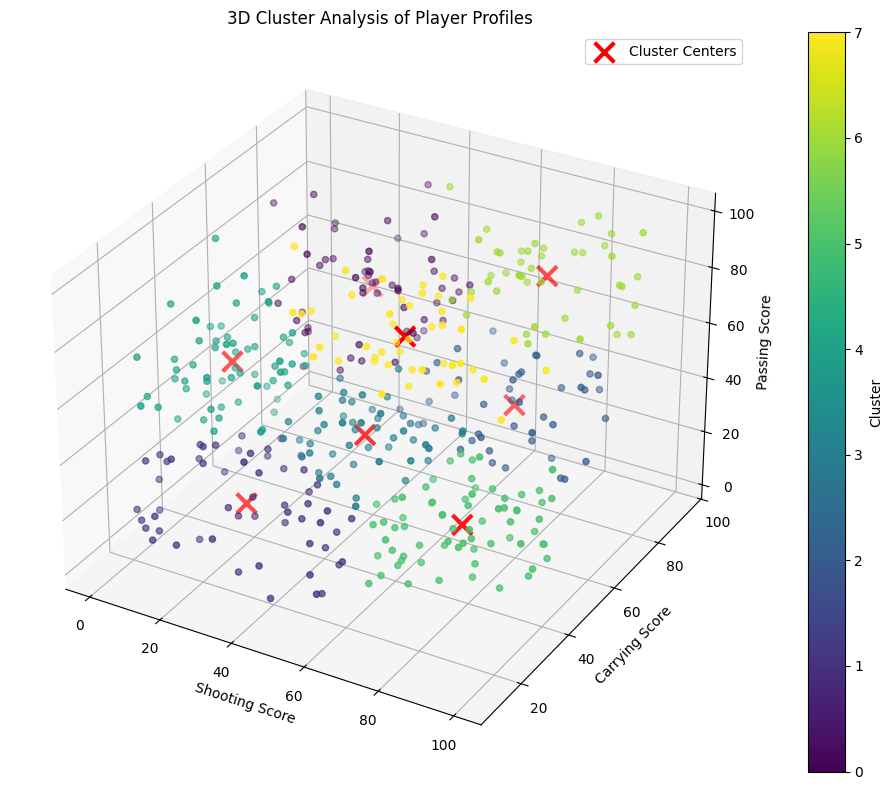

In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Define features for clustering
features = ["shooting_score", "carrying_score", "passing_score"]
X = df_triple_threat[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform k-means clustering
kmeans = KMeans(n_clusters=8, random_state=26)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to dataframe
df_clustered = df_triple_threat.copy()
df_clustered["cluster"] = clusters

# Get cluster centers in original scale
centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

cluster_profiles = {}
for i in range(8):
    cluster_data = df_clustered[df_clustered['cluster'] == i]
    
    profile = {
        'center': dict(zip(features, centers_original[i])),
        'size': len(cluster_data),
        'players': cluster_data[['player', 'team'] + features].to_dict('records'),
        'avg_scores': {
            'shooting': cluster_data['shooting_score'].mean(),
            'carrying': cluster_data['carrying_score'].mean(),
            'passing': cluster_data['passing_score'].mean()
        }
    }
    
    # Get the center scores
    shooting = profile['center']['shooting_score']
    carrying = profile['center']['carrying_score']
    passing = profile['center']['passing_score']
    
    # Define thresholds for what constitutes a "high" score
    high_threshold = 60  # scores above this are considered high
    
    # Determine cluster characteristics
    high_scores = []
    if shooting > high_threshold:
        high_scores.append('Shooting')
    if carrying > high_threshold:
        high_scores.append('Carrying')
    if passing > high_threshold:
        high_scores.append('Passing')
    
    if len(high_scores) > 1:
        profile['primary_attribute'] = ' & '.join(high_scores)
    else:
        # If no scores are particularly high, find the highest one
        scores = [('Shooting', shooting), ('Carrying', carrying), ('Passing', passing)]
        profile['primary_attribute'] = max(scores, key=lambda x: x[1])[0]
    
    cluster_profiles[i] = profile


# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all points
scatter = ax.scatter(df_clustered['shooting_score'],
                    df_clustered['carrying_score'],
                    df_clustered['passing_score'],
                    c=clusters,
                    cmap='viridis')

# Plot cluster centers
ax.scatter(centers_original[:, 0],
          centers_original[:, 1],
          centers_original[:, 2],
          c='red',
          marker='x',
          s=200,
          linewidth=3,
          label='Cluster Centers')

# Customize the plot
ax.set_xlabel('Shooting Score')
ax.set_ylabel('Carrying Score')
ax.set_zlabel('Passing Score')
ax.set_title('3D Cluster Analysis of Player Profiles')

# Add colorbar
plt.colorbar(scatter, label='Cluster')

# Add legend
plt.legend()

# Optional: Add text annotations for specific players (e.g., Liverpool players)
liverpool_players = df_clustered[df_clustered['player'].isin([
    'Mo Salah (19/20)', 
    'Roberto Firmino (19/20)', 
    'Sadio Mane (19/20)'
])]

for idx, player in liverpool_players.iterrows():
    ax.text(player['shooting_score'], 
            player['carrying_score'], 
            player['passing_score'], 
            player['player'],
            fontsize=8)

# Print cluster information
print("\nCluster Analysis:")
print("-" * 80)
for cluster_id, profile in cluster_profiles.items():
    print(f"\nCluster {cluster_id} - {profile['primary_attribute']} Specialists")
    print(f"Size: {profile['size']} players")
    print("\nCluster Center Scores:")
    print(f"- Shooting: {profile['center']['shooting_score']:.2f}")
    print(f"- Carrying: {profile['center']['carrying_score']:.2f}")
    print(f"- Passing:  {profile['center']['passing_score']:.2f}")
    
    print("\nExample Players (closest to center):")
    # Get players in this cluster
    cluster_players = df_clustered[df_clustered['cluster'] == cluster_id]
    
    # Calculate distance to cluster center for each player
    center = np.array([profile['center']['shooting_score'],
                      profile['center']['carrying_score'],
                      profile['center']['passing_score']])
    
    # Calculate distances and get top 5 closest players
    distances = []
    for idx, player in cluster_players.iterrows():
        point = np.array([player['shooting_score'],
                        player['carrying_score'],
                        player['passing_score']])
        distance = np.linalg.norm(point - center)
        distances.append((player['player'], player['team'], distance))
    
    # Sort by distance and show top 5
    distances.sort(key=lambda x: x[2])
    for player, team, dist in distances[:5]:
        print(f"- {player} ({team})")
    
    print("-" * 80)

plt.tight_layout()
plt.show()

In [34]:
# To print all players from a specific cluster (e.g., cluster 2)
cluster_number = 3  # Change this to whichever cluster you want to see

# Get all players from the cluster with their scores
cluster_players = df_clustered[df_clustered['cluster'] == cluster_number].sort_values(
    by=['shooting_score', 'carrying_score', 'passing_score'], 
    ascending=False
)[['player', 'team', 'shooting_score', 'carrying_score', 'passing_score']]

print(f"\nAll Players in Cluster {cluster_number}:")
print("-" * 80)
print(cluster_players.to_string(index=False))


All Players in Cluster 3:
--------------------------------------------------------------------------------
               player            team shooting_score carrying_score passing_score
        Patrik Schick      Leverkusen      99.885584      35.619794     19.576659
          Deniz Undav       Stuttgart      99.542334       43.79016     48.215103
      Victor Boniface      Leverkusen      99.427918      58.523799     39.264874
           Jhon Durán     Aston Villa      98.169336      44.563158     15.114416
        Mateo Retegui        Atalanta      97.597254      34.087414     28.993135
    Alexander Sørloth Atlético Madrid      97.254005      47.503204     34.010297
   Robert Lewandowski       Barcelona      97.254005      42.332265      30.83524
       Erling Haaland Manchester City      96.796339      38.936384     12.900458
 Valentín Castellanos           Lazio       95.76659      55.406178     33.975973
           Moise Kean      Fiorentina      93.249428      51.200229     